# Low Resource Language ASR model
### Lars Ericson, Catskills Research Company, OpenASR20

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

In [3]:
from glob import glob
import os, librosa
from tqdm.notebook import tqdm
from tokenizer import tokenizer
import numpy as np

## Language data

In [4]:
def text_of_file(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return f.read()

In [5]:
class Language:

    def __init__(self, language):
        self.stage='NIST'
        self.sample_rate=8000
        self.language=language
        self.load_training_corpus()

    def load_training_corpus(self):
        self.data_dir=f'{self.stage}/openasr20_{self.language}'
        self.build_dir=f'{self.data_dir}/build'
        self.build_transcription_split_dir=f'{self.build_dir}/transcription_split'
        self.build_transcription_split_filenames=glob(f'{self.build_transcription_split_dir}/*.txt')
        self.build_split_targets = [text_of_file(x) for x in tqdm(self.build_transcription_split_filenames)]
        self.build_split_roots = [os.path.basename(x)[0:-4] for x in self.build_transcription_split_filenames]
        self.build_audio_split_nr_dir=f'{self.build_dir}/audio_split_{self.sample_rate}'
        self.build_audio_split_nr_filenames=[f'{self.build_audio_split_nr_dir}/{x}.wav' for x in self.build_split_roots]
        self.build_split_sources = [librosa.load(src_fn, sr=self.sample_rate)[0] for src_fn in tqdm(self.build_audio_split_nr_filenames)]
        self.build_examples = list(zip(self.build_split_roots, self.build_split_sources, self.build_split_targets))

In [6]:
L=Language('amharic')

## Language Analysis

### all recordings

In [7]:
L.build_transcription_dir=f'{L.build_dir}/transcription'
L.build_transcription_filenames=glob(f'{L.build_transcription_dir}/*.txt')
L.N_recordings=len(L.build_transcription_filenames)
print('# 10-minute training recordings', L.N_recordings)

# 10-minute training recordings 122


### splits per recording

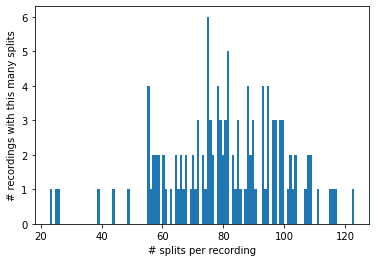

In [8]:
L.build_roots=[os.path.basename(x)[0:-4] for x in L.build_transcription_filenames]
L.N_splits_per_root=[len([x for x in L.build_split_roots if x.startswith(y)]) for y in L.build_roots]
plt.hist(L.N_splits_per_root,bins=L.N_recordings);
plt.xlabel('# splits per recording')
plt.ylabel('# recordings with this many splits');

### all splits

In [9]:
L.N_all_splits=len(L.build_split_roots)
L.N_all_splits

9842

### tokenized splits

In [10]:
L.build_split_targets_tokenized=[tokenizer(x) for x in L.build_split_targets]
L.build_split_targets_tokenized[0:2]

[['ነበር', 'እ', 'አዎ', 'እንዲው', 'ሳምንት', 'ነው', 'ያመመኝ', 'በቃ', 'በብሽቀት'], ['እሺ']]

### split length in words

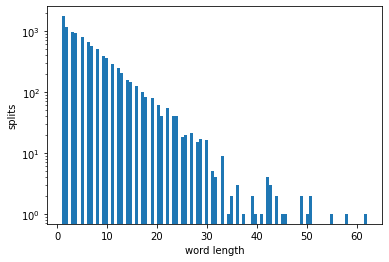

In [11]:
L.split_length_in_words=[len(x) for x in L.build_split_targets_tokenized]
plt.hist(L.split_length_in_words,bins=100);
plt.xlabel('word length')
plt.ylabel('splits')
plt.yscale('log');

### split length in graphemes

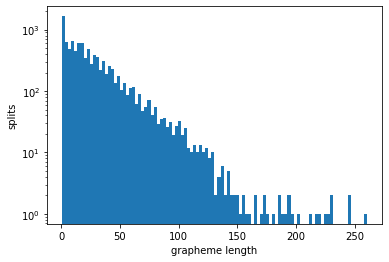

In [12]:
L.split_length_in_graphemes=[len(x) for x in L.build_split_targets]
plt.hist(L.split_length_in_graphemes,bins=100);
plt.xlabel('grapheme length')
plt.ylabel('splits')
plt.yscale('log');

### split length in audio samples and seconds

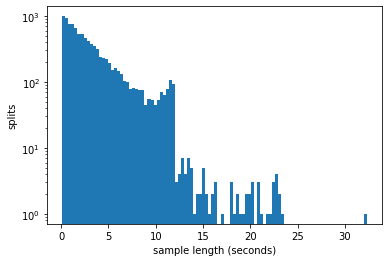

In [13]:
L.split_length_in_samples=np.array([len(x) for x in L.build_split_sources])
L.split_length_in_seconds=L.split_length_in_samples/L.sample_rate
L.min_split_length_in_samples=min(L.split_length_in_samples)
L.max_split_length_in_samples=max(L.split_length_in_samples)
L.mean_split_length_in_samples=np.mean(L.split_length_in_samples)
L.median_split_length_in_samples=np.median(L.split_length_in_samples)
plt.hist(L.split_length_in_seconds,bins=100);
plt.xlabel('sample length (seconds)')
plt.ylabel('splits')
plt.yscale('log');

In [18]:
L.samples_per_grapheme = L.split_length_in_samples/L.split_length_in_graphemes

### all words in examples

In [14]:
L.all_words=list(sorted(set([item for sublist in L.build_split_targets_tokenized for item in sublist])))
L.all_words[0:5]

['ሀ', 'ሀላፊነቱን', 'ሀላፊነት', 'ሀላፊው', 'ሀል']

### all graphemes in examples

In [15]:
L.all_graphemes=list(sorted(set(''.join(L.all_words))))
L.all_graphemes[0:5]

['ሀ', 'ሁ', 'ሂ', 'ሃ', 'ሄ']

### analysis prior to splitting

SPEECH
hours of training speech 20.333333333333332

WORDS
words 11876
mean word length in graphemes 4.554900639946109
median word length in graphemes 4.0
min word length in graphemes 1
max word length in graphemes 12

GRAPHEMES
graphemes 234


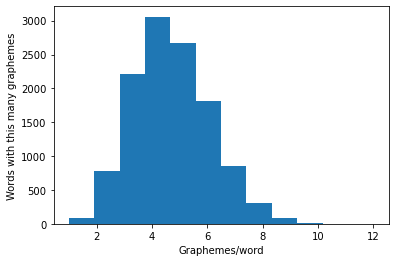

In [16]:
print('SPEECH')
# N all speech in recordings
L.hours_of_build_speech=10*L.N_recordings/60
print('hours of training speech', L.hours_of_build_speech)
print()
print('WORDS')
# N all words in examples
L.N_all_words=len(L.all_words)
print('words', L.N_all_words)
# Word lengths
L.word_lengths_in_graphemes=[len(x) for x in L.all_words]
plt.hist(L.word_lengths_in_graphemes, bins=12)
plt.xlabel('Graphemes/word')
plt.ylabel('Words with this many graphemes')
# Mean word length
print('mean word length in graphemes', np.mean(L.word_lengths_in_graphemes))
# Median word length
print('median word length in graphemes', np.median(L.word_lengths_in_graphemes))
# Min word length
print('min word length in graphemes', min(L.word_lengths_in_graphemes))
# Max word length
print('max word length in graphemes', max(L.word_lengths_in_graphemes))
print()
print('GRAPHEMES')
# N all graphemes in examples
L.N_all_graphemes=len(L.all_graphemes)
print('graphemes', L.N_all_graphemes)

### Language analysis on splits

SPEECH


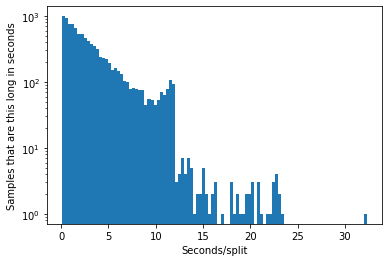

mean seconds/split 3.2513701483438324
median seconds/split 2.2430624999999997
min seconds/split 0.112125
max seconds/split 32.288875

WORDS


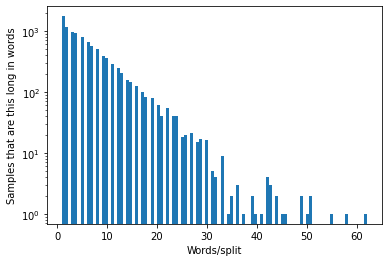

mean words/split 6.447876447876448
median words/split 5.0
min words/split 1
max words/split 62

GRAPHEMES


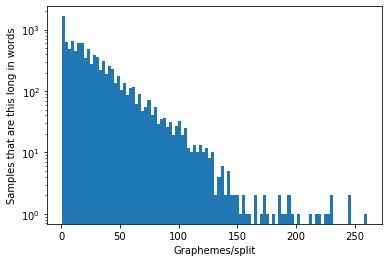

mean graphemes/split 26.27148953464743
median graphemes/split 19.0
min graphemes/split 1
max graphemes/split 260

AUDIO SAMPLES PER WORD


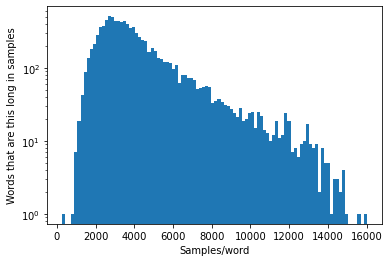

min 277 (0.035 seconds/word)
max 16005 (2.001 seconds/word)
mean 4213 (0.527 seconds/word)
median 3586 (0.448 seconds/word)

AUDIO SAMPLES PER GRAPHEME


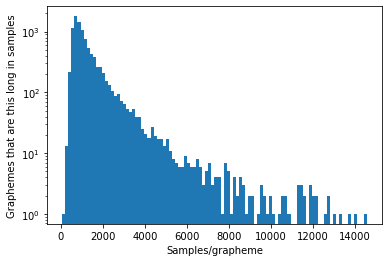

min 67 (0.008 seconds/grapheme)
max 14560 (1.820 seconds/grapheme)
mean 1350 (0.169 seconds/grapheme)
median 971 (0.121 seconds/grapheme)


In [19]:
print('SPEECH')
plt.hist(L.split_length_in_seconds, bins=100)
plt.xlabel('Seconds/split')
plt.ylabel('Samples that are this long in seconds')
plt.yscale('log')
plt.show();
# mean split speech length in seconds
L.mean_split_speech_length_in_seconds=np.mean(L.split_length_in_seconds)
print('mean seconds/split', L.mean_split_speech_length_in_seconds)
# median split speech length
L.median_split_speech_length_in_seconds=np.median(L.split_length_in_seconds)
print('median seconds/split', L.median_split_speech_length_in_seconds)
# min split speech length
L.min_split_speech_length_in_seconds=min(L.split_length_in_seconds)
print('min seconds/split', L.min_split_speech_length_in_seconds)
# max split speech length
L.max_split_speech_length_in_seconds=max(L.split_length_in_seconds)
print('max seconds/split', L.max_split_speech_length_in_seconds)
print()
print('WORDS')
plt.hist(L.split_length_in_words, bins=100)
plt.xlabel('Words/split')
plt.ylabel('Samples that are this long in words')
plt.yscale('log')
plt.show();
# mean split word length
L.mean_split_word_length=np.mean(L.split_length_in_words)
print('mean words/split', L.mean_split_word_length)
# median split word length
L.median_split_word_length=np.median(L.split_length_in_words)
print('median words/split', L.median_split_word_length)
# min split word length
L.min_split_word_length=min(L.split_length_in_words)
print('min words/split', L.min_split_word_length)
# max split word length
L.max_split_word_length=max(L.split_length_in_words)
print('max words/split', L.max_split_word_length)
print()
print('GRAPHEMES')
plt.hist(L.split_length_in_graphemes, bins=100)
plt.xlabel('Graphemes/split')
plt.ylabel('Samples that are this long in words')
plt.yscale('log')
plt.show();
# mean split grapheme length
L.mean_split_grapheme_length=np.mean(L.split_length_in_graphemes)
print('mean graphemes/split', L.mean_split_grapheme_length)
# median split grapheme length
L.median_split_grapheme_length=np.median(L.split_length_in_graphemes)
print('median graphemes/split', L.median_split_grapheme_length)
# min split graphemes length
L.min_split_grapheme_length=min(L.split_length_in_graphemes)
print('min graphemes/split', L.min_split_word_length)
# max split graphemes length
L.max_split_grapheme_length=max(L.split_length_in_graphemes)
print('max graphemes/split', L.max_split_grapheme_length)
print()
print('AUDIO SAMPLES PER WORD')
L.samples_per_word=L.split_length_in_samples/L.split_length_in_words
plt.hist(L.samples_per_word, bins=100)
plt.xlabel('Samples/word')
plt.ylabel('Words that are this long in samples')
plt.yscale('log')
plt.show();
L.min_samples_per_word=int(min(L.samples_per_word))
L.max_samples_per_word=int(max(L.samples_per_word))
L.mean_samples_per_word=int(np.mean(L.samples_per_word))
L.median_samples_per_word=int(np.median(L.samples_per_word))
print(f'min {L.min_samples_per_word} ({L.min_samples_per_word/L.sample_rate:.3f} seconds/word)')
print(f'max {L.max_samples_per_word} ({L.max_samples_per_word/L.sample_rate:.3f} seconds/word)')
print(f'mean {L.mean_samples_per_word} ({L.mean_samples_per_word/L.sample_rate:.3f} seconds/word)')
print(f'median {L.median_samples_per_word} ({L.median_samples_per_word/L.sample_rate:.3f} seconds/word)')
print()
print('AUDIO SAMPLES PER GRAPHEME')
plt.hist(L.samples_per_grapheme, bins=100)
plt.xlabel('Samples/grapheme')
plt.ylabel('Graphemes that are this long in samples')
plt.yscale('log')
plt.show();
L.min_samples_per_grapheme=int(min(L.samples_per_grapheme))
L.max_samples_per_grapheme=int(max(L.samples_per_grapheme))
L.mean_samples_per_grapheme=int(np.mean(L.samples_per_grapheme))
L.median_samples_per_grapheme=int(np.median(L.samples_per_grapheme))
print(f'min {L.min_samples_per_grapheme} ({L.min_samples_per_grapheme/L.sample_rate:.3f} seconds/grapheme)')
print(f'max {L.max_samples_per_grapheme} ({L.max_samples_per_grapheme/L.sample_rate:.3f} seconds/grapheme)')
print(f'mean {L.mean_samples_per_grapheme} ({L.mean_samples_per_grapheme/L.sample_rate:.3f} seconds/grapheme)')
print(f'median {L.median_samples_per_grapheme} ({L.median_samples_per_grapheme/L.sample_rate:.3f} seconds/grapheme)')

## Sub splitting based on words per split and average samples per grapheme (imperfect, introduces error)

### Start by visualizing and skipping single-word samples but also doing the language analysis on the set

## Language analysis after sub-splitting

## ASR end-to-end speech-to-grapheme model stacked on top of grapheme-to-grapheme corrector model

In [ ]:
C.extension='_gradscaler'
C.batch_size=12
C.save_every = 5
C.start_from = 246

In [ ]:

import json, sys, os, librosa, random, math, time, torch
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')
os.environ['IN_JUPYTER']='True'
import numpy as np
import pandas as pd

from itertools import groupby
from operator import itemgetter
import soundfile as sf
from utils import constant
from utils.functions import load_model
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from clip_ends import clip_ends
import torch.optim as optim
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset
import matplotlib.ticker as ticker
from IPython.display import Audio
from unidecode import unidecode
from seq_to_seq import *

In [ ]:
files=glob(f'{C.nr_dir}/*')
n_samples=len(files)
samples=list(sorted([(librosa.load(audio_file, sr=C.sample_rate)[0].shape[0], audio_file) for audio_file in files]))

In [ ]:
samples[0]

In [ ]:
long_samples=samples[4842:]

In [ ]:
long_sample=long_samples[0][1]
long_sample

In [ ]:
tgt_fn=f"{long_sample[0:-4].replace('/audio_split_8000','/transcription_split')}.txt"
tgt_fn

In [ ]:
gold_tgt=open(tgt_fn).read()
gold_tgt

In [ ]:
sound=librosa.load(long_sample, sr=C.sample_rate)[0]

In [ ]:
def split_on_longest_silence(sound, sample_rate, _cutoff = 0.0014, debug=None):
    N=100
    min_gap=0.04*sample_rate
    audio_moving=np.convolve(sound**2, np.ones((N,))/N, mode='same') 
    if debug:
        print(f'average energy over {N} sample window')
        plt.figure(figsize=(40,4))
        plt.plot(sound)
        plt.plot(audio_moving);
        plt.title(unidecode(debug))
        plt.show()
    if 0:
        threshold=0.3
        amplitudes=np.sort(audio_moving)
        n_amp=audio_moving.shape[0]
        cutoff=amplitudes[int(n_amp*threshold)]
    else:
        cutoff = _cutoff
    if debug:
        print('cutoff', cutoff)
    silence_mask=audio_moving < cutoff
    groups = [[i for i, _ in group] for key, group in groupby(enumerate(silence_mask), key=itemgetter(1)) if key]
    boundaries=[(x[0],x[-1]) for x in groups]
    silences=[(x,(y-N)) for x,y in boundaries if y-x > min_gap]
    if not silences:
        print('no silence')
        display(Audio(sound, rate=C.sample_rate))
        return (sound, None)
    if debug:
        print('#silences', len(silences))
        plt.figure(figsize=(50,8))
        plt.plot(sound);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        for (x1,x2) in silences:
            plt.plot([x1,x2],[0,0],linewidth=5,color='red')
        plt.title('sound and detected silence')
        plt.show()
    longest_silence=list(sorted([(y-x, (x,y)) for x,y in silences]))[-1][1]
    midpoint_of_longest_silence=longest_silence[0]+((longest_silence[1]-longest_silence[0])//2)
    speech=[(0,midpoint_of_longest_silence), (midpoint_of_longest_silence,sound.shape[0])]
    sounds=[clip_ends(sound[a:b], 0.0008) for a,b in speech]
    if debug:
        spliced=np.hstack(sounds)
        plt.figure(figsize=(50,8))
        plt.plot(spliced);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        plt.title('spliced')
        print(f'sound: {unidecode(debug)}')
        display(Audio(sound, rate=C.sample_rate))
        print('spliced')
        display(Audio(spliced, rate=C.sample_rate))
        for i, sound in enumerate(sounds):
            print('segment', i)
            display(Audio(sound, rate=C.sample_rate))
            plt.figure(figsize=(50,8))
            plt.plot(sound);
            plt.xlabel('seconds')
            plt.ylabel('amplitude');
            plt.title(f"segment {i}")
        plt.show()
    return sounds

In [ ]:
s1,s2=split_on_longest_silence(sound, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s1a,s1b=split_on_longest_silence(s1, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s2a,s2b=split_on_longest_silence(s2, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s2b1,s2b2=split_on_longest_silence(s2b, C.sample_rate,  0.001, gold_tgt)

In [ ]:
s2b1a,s2b1b=split_on_longest_silence(s2b1, C.sample_rate,  0.001, gold_tgt)

In [ ]:
s2b2a,s2b2b=split_on_longest_silence(s2b2, C.sample_rate,  0.001, gold_tgt)

In [ ]:
unidecode(gold_tgt)

In [ ]:
!mkdir -p frob
!rm frob/*

In [ ]:
clips=[]
for i, sound in enumerate(sounds):
    fn=f"frob/clip_{i}.wav"
    sf.write(fn, sound, C.sample_rate)
    clips.append(fn)

In [ ]:
text='infer.txt'
manifest_fn='manifest.csv'
manifest='\n'.join([f'{audio},{text}' for audio in clips])
with open(manifest_fn, 'w') as f:        plt.show()
    f.write(manifest)

In [ ]:
!cat manifest.csv

In [ ]:
args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = C.grapheme_dictionary_fn
args.lr = 1e-4
args.name = C.model_name
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=C.sample_rate
args.continue_from=C.best_model
args.augment=True
audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

In [ ]:
with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))
# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(constant.args.continue_from)

In [ ]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=[manifest_fn], 
                                label2id=label2id, normalize=True, augment=args.augment)
args.batch_size=1
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

strs_hyps=[]
for i, (data) in enumerate(tqdm(train_loader)):
    src, tgt, _, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)
    seq_length = pred.size(1)
    for ut_hyp in hyp_seq:
        str_hyp = ""
        for x in ut_hyp:
            if int(x) == constant.PAD_TOKEN:
                break
            str_hyp = str_hyp + id2label[int(x)]
        strs_hyps.append(str_hyp)
for j in range(len(strs_hyps)):
    strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')

In [ ]:
gold_tgt = ' '.join([x.strip() for x in gold_tgt.split(' ') if x])
gold_tgt

In [ ]:
pred=' '.join(strs_hyps)
pred

In [ ]:
error_correction_training_fn='frob/pred_gold.tsv'
with open(error_correction_training_fn, 'w', encoding='utf-8') as f:
    f.write(f"{gold_tgt}\t{pred}")

In [ ]:
!cat frob/pred_gold.tsv

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
from torchtext.data import Iterator

In [ ]:
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [ ]:
train_iterator = Iterator(train_data, batch_size=1)

In [ ]:
gold_fns=list(sorted(glob(f'{C.build_dir}/transcription_split/*.txt')))
len(gold_fns)
import os
goldrows=[]
for fn in gold_fns:
    with open(fn, 'r', encoding='utf-8') as f:
        goldrows.append(f.read())

MAX_LENGTH=max(len(x) for x in goldrows)+10
MAX_LENGTH

graphemes=''.join([x for x in C.grapheme_dictionary])

MIN_FREQ=1

In [ ]:
SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

In [ ]:
TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model_fn='tut6-model.pt'

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
model.train()

In [ ]:
for j in range(100):
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        epoch_loss += loss.item()
        
    print(j, epoch_loss)

In [ ]:
pred=output.argmax(1).cpu().detach().numpy()
pred

In [ ]:
''.join([SRC.vocab.itos[x] for x in src.cpu().numpy()[0]])

In [ ]:
silver=''.join([TRG.vocab.itos[x] for x in trg.cpu().numpy()]).split('<eos>')[0]
silver

In [ ]:
pred=''.join([TRG.vocab.itos[x] for x in pred]).split('<eos>')[0]
pred

In [ ]:
from utils.metrics import calculate_cer, calculate_wer

In [ ]:
calculate_cer(pred, silver)

In [ ]:
calculate_wer(pred, silver)